<a href="https://colab.research.google.com/github/caesarcc/pucminas-tcc-fake-news-detection/blob/main/passo04_treino_avaliacao_modelo_BERTimbau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Treino e Avaliação do Modelo BERTimbau

### Iniciando pela configuração do Google Colab

In [1]:
!pip install -q transformers

     |████████████████████████████████| 4.4 MB 13.7 MB/s 
     |████████████████████████████████| 596 kB 76.5 MB/s 
     |████████████████████████████████| 6.6 MB 68.6 MB/s 
     |████████████████████████████████| 101 kB 12.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Importação de bibliotecas utilizadas no treino e avaliação
import datetime
import os
import random
import time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from IPython.display import display
from sklearn.metrics import (accuracy_score, auc, classification_report, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve)
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          get_linear_schedule_with_warmup)
from transformers.file_utils import is_torch_available

In [4]:
#Configurações de ambiente
%matplotlib inline
# limites de impressão para o pandas
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 250)
# configura tema dos gráficos
sns.set_theme(style="white")

### Carrega dados processados no passo 1

In [5]:
dados = pd.read_csv(r'/content/drive/MyDrive/PUC/TCC/dados/dataset_tratado.csv', sep = ',')
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7567 entries, 0 to 7566
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   texto                          7567 non-null   object
 1   classe                         7567 non-null   int64 
 2   texto_lematizado               7567 non-null   object
 3   qtde_lematizado                7567 non-null   int64 
 4   texto_wordcloud                7567 non-null   object
 5   texto_wordcloud_nomes_numeros  7567 non-null   object
dtypes: int64(2), object(4)
memory usage: 354.8+ KB


### Geração de seed  
Rotina para garantir a reprodução dos resultados mesmo que o ambiente for reiniciado.  
Semente aplicada às libs random, numpy e torch.

In [6]:
RANDOM_SEED = 42
def garantir_reprodutividade(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            return "cuda"
    return "cpu"

device_disponivel = garantir_reprodutividade(RANDOM_SEED)

### Gera datasets de treino, validação e teste

In [8]:
# Formata o dataframe como x, y para gerar os dataloaders
dados_xy = [{ 'texto': x, 'classe': y } for (x, y) in 
            zip(dados['texto_lematizado'].to_list(), 
                dados['classe'].to_list())]

# Separa 70% para treino, 10% para validação e 20% para teste
dados_treino, dados_validacao, dados_teste = np.split(
    dados_xy, [
      int(.7*len(dados)), 
      int(.8*len(dados))
])
display(f"Total: {dados.shape[0]}, Treinamento: {len(dados_treino)}, " 
  f"Validação: {len(dados_validacao)}, Teste: {len(dados_teste)}")

# definião dos leitures do dataset
tamanho_lote = 16
treino_loader = DataLoader(dados_treino, batch_size=tamanho_lote, shuffle=True)
val_loader = DataLoader(dados_validacao, batch_size=tamanho_lote, shuffle=True)
teste_loader = DataLoader(dados_teste, batch_size=tamanho_lote, shuffle=True)

'Total: 7567, Treinamento: 5296, Validação: 757, Teste: 1514'

### Carregando o modelo pré-treinado BERTimbau

In [9]:
MODELO_LOCAL = "/content/drive/MyDrive/PUC/TCC/modelos/classificador_bertimbau"
MODELO_ORIGEM = "neuralmind/bert-large-portuguese-cased"

# carrega tokenizador
tokenizer = AutoTokenizer.from_pretrained(
    MODELO_ORIGEM, 
    # não altera case, pois o modelo é case-sensitive
    do_lower_case=False
)
# carrega pesos do modelo "BERTimbau"
model_bert = AutoModelForSequenceClassification.from_pretrained(
    MODELO_ORIGEM, 
    num_labels=2          # número de classes da classificação
).to(device_disponivel)   # coloca o modelo para rodar na GPU
# configura otimizador com learning rate baixo
optimizer = torch.optim.AdamW(model_bert.parameters(), lr = 1e-5)

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from th

### Definição do método de avaliação do modelo

In [10]:
def avaliar_modelo(modelo, dados):
  modelo.eval() # coloca o modelo em avaliação
  classes_real, classes_pred = [], []
  for idx_lote, entrada in enumerate(dados):
    # pega os dados do lote
    textos_lote, classes_lote = entrada['texto'], entrada['classe']
    # tokeniza entrada
    inputs = tokenizer(textos_lote, return_tensors='pt', padding=True,
                       truncation=True, max_length=300).to(device_disponivel)
    # realiza predição
    output = modelo(**inputs)
    # retorna indice de maior valor na predição
    pred_classes = torch.argmax(output.logits, 1)
    # salva retorno para medição
    classes_real.extend(classes_lote.tolist())
    classes_pred.extend(pred_classes.tolist())
    # exibe progresso
    if (idx_lote+1) % (tamanho_lote * 2) == 0:
      print('Progresso:', round(idx_lote / len(dados), 2), idx_lote)
  
  # Gera relatório a cada avaliação
  print(classification_report(classes_real, classes_pred, labels=[0, 1], 
                              target_names=['Confiável', 'Falso']))
  # Obtem f1 e acurácia para retornar
  f1 = f1_score(classes_real, classes_pred, average='weighted')
  acuracia = accuracy_score(classes_real, classes_pred)
  return f1, acuracia

### Roda treino principal  
O treino realiza avaliação a cada época
Quando a métrica F1 melhorar, um modelo local será salvo
Caso a métrica F1 não melhore por duas épocas, o treino é terminado

In [12]:
epocas = 5          # número de épocas do treini
parar_treino = 2    # define quantas vezes o treino repete sem melhorar
max_f1, repetir_treino = 0, 0

for epoch in range(epocas):
  model_bert.train()
  perdas = []
  for idx_lote, entrada in enumerate(treino_loader):
    textos_lote, classes_lote = entrada['texto'], entrada['classe']

    # tokeniza entrada
    inputs = tokenizer(textos_lote, return_tensors='pt', padding=True,
                       truncation=True, max_length=300).to(device_disponivel)
    # treina no lote atual
    output = model_bert(**inputs, 
                        labels=classes_lote.to(device_disponivel))
    # Salva o loss
    perda = output.loss
    perdas.append(float(perda))
    # Backpropagation
    perda.backward()
    optimizer.step()
    optimizer.zero_grad()

    # imprime processo
    if (idx_lote+1) % (tamanho_lote * 2) == 0:
      print("Época: {} [{}/{} ({:.0f}%)]".format(epoch, idx_lote+1, \
        len(dados_treino), 100. * idx_lote / len(dados_treino)) \
        + "\tPerda: {:.6f}\tPerda Total: {:.6f}".format(
            float(perda) , round(sum(perdas) / len(perdas), 5)))
  
  f1, acc = avaliar_modelo(model_bert, val_loader)
  print('F1: ', f1, 'Acurácia: ', acc)
  if f1 > max_f1:
    model_bert.save_pretrained(MODELO_LOCAL)
    max_f1 = f1
    repeat = 0
    print('Salvando melhor modelo...')
  else:
    repetir_treino += 1
  if repetir_treino == parar_treino:
    break

RuntimeError: ignored

### Tokeniza textos

In [ ]:
campo_texto = 'texto_lematizado' #'texto_wordcloud_nomes_numeros'
dados_token = dados[['classe', campo_texto]].copy()
dados_token['TOKENS'] = dados_token[campo_texto].progress_apply(
    lambda x: np.array(
        tokenizer.encode(x, 
                         padding='max_length', 
                         truncation=True, 
                         max_length=300)
    ))
dados_token['LABELS'] = dados_token['classe']
dados_token = dados_token[['TOKENS','LABELS']]

  0%|          | 0/7567 [00:00<?, ?it/s]

### Separando treino, teste e validação

In [ ]:
# Reserva 70% dos dados para treino, fracionado aleatoriamente e com a seed selecionada
dados_treino, dados_resto = np.split(dados_token.sample(frac=1), [int(.7*len(dados_token))])

# Dos 30% restante separa 60 para teste e 40 para validação.
dados_teste, dados_validacao = np.split(dados_resto.sample(frac=1), [int(.6*len(dados_resto))])
dados_resto = pd.DataFrame()
display(f"Treinamento: {dados_treino.shape[0]}, Teste: {dados_teste.shape[0]}, Validação: {dados_validacao.shape[0]}")

'Treinamento: 5296, Teste: 1362, Validação: 909'

### Preparando o fine-tunning do modelo BERTimbau

In [ ]:
epocas = 5
tamanho_lote = 16
parar_se_nao_evoluir = 2

# Conversão dos tokens de treino e teste em tensores
treino_valores = torch.tensor(np.array(dados_treino['TOKENS'].to_list())).to(device_disponivel)
treino_classes = torch.tensor(np.array(dados_treino.LABELS.values)).to(device_disponivel)
teste_valores = torch.tensor(np.array(dados_teste['TOKENS'].to_list())).to(device_disponivel)
teste_classes = torch.tensor(np.array(dados_teste.LABELS.values)).to(device_disponivel)

# gera dataset e leitor de dados de treino
treino_dados = TensorDataset(treino_valores, treino_classes)
treino_leitor = DataLoader(treino_dados, 
                           sampler=RandomSampler(treino_dados), 
                           batch_size=tamanho_lote)

# gera dataset e leitor de dados de validação

validacao_dados = TensorDataset(validacao_valores, validacao_classes)
validacao_leitor = DataLoader(validacao_dados, 
                              sampler=SequentialSampler(validacao_dados), 
                              batch_size=tamanho_lote)

#passos_total = len(treino_leitor) * epocas
# configura otimizador e scheduler para controlar hyperparametros
optimizer = torch.optim.AdamW(
    model_bert.parameters(), 
    lr = 1e-5
)
scheduler = get_linear_schedule_with_warmup(
    optimizer #, 
    #num_warmup_steps = 0, 
    #num_training_steps = passos_total
)

### Treinamento modelo

In [ ]:
estatisticas = []
inicio_total = time.time()

for epoca in range(0, epocas):
    print('\n======== Época {:} / {:} ========'.format(epoca + 1, epocas))
    print('Treinando...')
    inicio_processo = time.time()

    # Reinicia o loss a cada época
    loss_por_epoca = 0
    model_bert.train()
    for passo, lote in enumerate(treino_leitor):
        # imprime processo a cada 40 passos
        if passo % 40 == 0 and not passo == 0:
            tempo = format_time(time.time() - inicio_processo)
            print('  Passo {:>5,}  de  {:>5,}.  Tempo decorrido: {:}.'.format(
                passo, len(treino_leitor), tempo))

        lote_valores = lote[0].to(device_disponivel)
        lote_classes = lote[1].to(device_disponivel)

        model_bert.zero_grad()

        outputs = model_bert(lote_valores,
                             token_type_ids=None,
                             labels=lote_classes)
        loss_por_epoca += outputs.loss.item()
        outputs.loss.backward()
        torch.nn.utils.clip_grad_norm_(model_bert.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calcula a média do loss sobre todos lotes
    loss_treino_media = loss_por_epoca / len(treino_leitor)

    tempo_por_epoca = format_time(time.time() - inicio_processo)
    print("\n  Média do loss de treino: {0:.2f}".format(loss_treino_media))
    print("  Tempo do treino: {:}".format(tempo_por_epoca))

    print("\nValidando...")
    inicio_processo = time.time()

    # Coloca o modelo em modo de validação
    model_bert.eval()

    # reseta variáveis para validação por epoca
    validacao_acuracia_total = 0
    validacao_loss_total = 0

    for lote in validacao_leitor:

        lote_valores = lote[0].to(device_disponivel)
        lote_classes = lote[1].to(device_disponivel)

        with torch.no_grad():

            outputs = model_bert(lote_valores,
                                   token_type_ids=None,
                                   labels=lote_classes)

        classes_previstas = outputs.logits.detach().cpu().numpy()
        classes = lote_classes.to('cpu').numpy()
        predicao = np.argmax(classes_previstas, axis=1).flatten()
        classes = classes.flatten()
        validacao_acuracia_total += np.sum(predicao == classes) / len(classes)

    # mostra a acurácia de cada avaliação.
    validacao_acuracia_media = validacao_acuracia_total / len(validacao_leitor)
    print("  Acurácia: {0:.2f}".format(validacao_acuracia_media))

    # calcula a média da perda nos lotes.
    validacao_loss_medio = validacao_loss_total / len(validacao_leitor)

    # mede o tempo de cada avaliação.
    validation_time = format_time(time.time() - inicio_processo)

    print("  Loss de validação: {0:.2f}".format(validacao_loss_medio))
    print("  Tempo de validação: {:}".format(validation_time))

    # grava as estatísticas por época.
    estatisticas.append(
        {
            'epoca': epoca + 1,
            'Loss de Treinamento': loss_treino_media,
            'Loss de Validação': validacao_loss_medio,
            'Acurácia de Validação': validacao_acuracia_media,
            'Tempo de Treino': tempo_por_epoca,
            'Tempo de Validação': validation_time
        }
    )
print("\nTreinamento completo!")
print("Tempo total do treino {:} (h:mm:ss)".format(format_time(time.time()-inicio_total)))


======== Época 1 / 5 ========
Treinando...
  Passo    40  de    331.  Tempo decorrido: 0:00:33.
  Passo    80  de    331.  Tempo decorrido: 0:01:06.
  Passo   120  de    331.  Tempo decorrido: 0:01:39.
  Passo   160  de    331.  Tempo decorrido: 0:02:12.
  Passo   200  de    331.  Tempo decorrido: 0:02:45.
  Passo   240  de    331.  Tempo decorrido: 0:03:18.
  Passo   280  de    331.  Tempo decorrido: 0:03:51.
  Passo   320  de    331.  Tempo decorrido: 0:04:25.

  Média do loss de treino: 0.28
  Tempo do treino: 0:04:34

Validando...
  Acurácia: 0.96
  Loss de validação: 0.00
  Tempo de validação: 0:00:15

======== Época 2 / 5 ========
Treinando...
  Passo    40  de    331.  Tempo decorrido: 0:00:33.
  Passo    80  de    331.  Tempo decorrido: 0:01:06.
  Passo   120  de    331.  Tempo decorrido: 0:01:39.
  Passo   160  de    331.  Tempo decorrido: 0:02:12.
  Passo   200  de    331.  Tempo decorrido: 0:02:45.
  Passo   240  de    331.  Tempo decorrido: 0:03:18.
  Passo   280  de    33

### Validação do Modelo tunado

In [ ]:
# Conversão dos tokens em tensores
validacao_valores = torch.tensor(np.array(dados_validacao['TOKENS'].to_list())).to(device_disponivel)
validacao_classes = torch.tensor(np.array(dados_validacao.LABELS.values)).to(device_disponivel)

# gera dataset e leitor de dados de teste
teste_dados = TensorDataset(teste_valores, teste_classes)
teste_leitor = DataLoader(teste_dados, 
                          sampler=SequentialSampler(teste_dados), 
                          batch_size=tamanho_lote)
# Colocar o modelo em modo de avaliação
model_bert.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
classes_previstas , classes_verdadeiras = [], []

for lote in teste_leitor:
    # coloca o lote na GPUS
    lote = tuple(t.to(device_disponivel) for t in lote)

    lote_valores, lote_classes = lote

    with torch.no_grad():
        outputs = model_bert(lote_valores, token_type_ids=None)

    # Retorna as prediões e classes de GPU para a CPU
    outputs = outputs.logits.detach().cpu().numpy()
    classes = lote_classes.to('cpu').numpy()

    # Salva as predições e as classes corretos
    classes_previstas.append(outputs)
    classes_verdadeiras.append(classes)      

In [ ]:
# prepara resultado
lista_previsoes = np.concatenate(classes_previstas, axis=0)
lista_previsoes = np.argmax(lista_previsoes, axis=1).flatten()
lista_classes_verdadeiras = np.concatenate(classes_verdadeiras, axis=0)

### Relatório de classificação

In [ ]:
print(classification_report(lista_classes_verdadeiras, lista_previsoes,target_names=['confiável','falso']))

              precision    recall  f1-score   support

   confiável       0.95      0.95      0.95       680
       falso       0.95      0.95      0.95       682

    accuracy                           0.95      1362
   macro avg       0.95      0.95      0.95      1362
weighted avg       0.95      0.95      0.95      1362



### Curva ROC

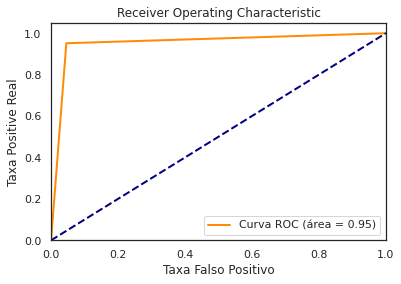

In [ ]:
fpr, tpr, _ = roc_curve(lista_classes_verdadeiras, lista_previsoes)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa Falso Positivo')
plt.ylabel('Taxa Positive Real')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Gráfico da Acurácia

In [ ]:
print(accuracy_score(lista_classes_verdadeiras, lista_previsoes))

0.9530102790014684


### Matriz de confusão

[[649  31]
 [ 33 649]]


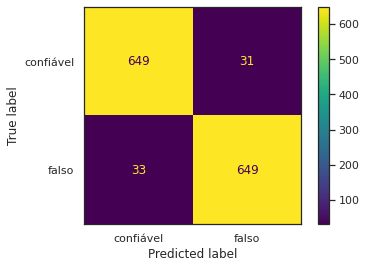

In [ ]:
conf = confusion_matrix(lista_classes_verdadeiras, lista_previsoes)
print(conf)
cmd = ConfusionMatrixDisplay(conf, display_labels=['confiável','falso'])
cmd.plot()

### Gera as estatísticas do treino

In [ ]:
# Cria um dataframe das estatísticas
pd.set_option('precision', 2)
df_estatisticas = pd.DataFrame(data=estatisticas)
df_estatisticas = df_estatisticas.set_index('epoca')

### Curva de aprendizado

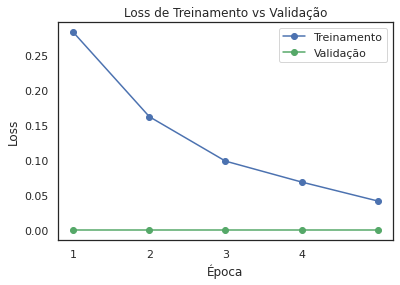

In [ ]:
plt.figure()
# Mostra curva de aprendizado.
plt.plot(df_estatisticas['Loss de Treinamento'], 'b-o', label="Treinamento")
plt.plot(df_estatisticas['Loss de Validação'], 'g-o', label="Validação")
plt.title("Loss de Treinamento vs Validação")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

### Acurácia

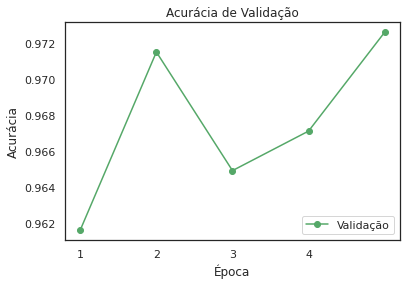

In [ ]:
plt.figure()
plt.plot(df_estatisticas['Acurácia de Validação'], 'g-o', label="Validação")
plt.title("Acurácia de Validação")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend(loc="lower right")
plt.xticks([1, 2, 3, 4])
plt.show()

### Salvando o melhor modelo

In [ ]:
CAMINHO_MODELO = "/content/drive/MyDrive/PUC/TCC/modelos/classificador_bertimbau"
model_bert.save_pretrained(f"{CAMINHO_MODELO}")
tokenizer.save_pretrained(f"{CAMINHO_MODELO}")

('/content/drive/MyDrive/PUC/TCC/modelos/classificador_bertimbau/tokenizer_config.json',
 '/content/drive/MyDrive/PUC/TCC/modelos/classificador_bertimbau/special_tokens_map.json',
 '/content/drive/MyDrive/PUC/TCC/modelos/classificador_bertimbau/vocab.txt',
 '/content/drive/MyDrive/PUC/TCC/modelos/classificador_bertimbau/added_tokens.json')